In [1]:
import torch

In [2]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [21]:
from common.multiprocessing_env import SubprocVecEnv
from common.minipacman import MiniPacman
from common.rollout_encoder import RolloutEncoder
from common.imagination_core import ImaginationCore
from common.i2a import I2A
from common import pacman_util as putil
from common.environment_model import EnvModel
from common.actor_critic import ActorCritic
from common import torch_util as tutil

In [4]:
mode = 'regular'
env = MiniPacman(mode, 1000)
state_shape = env.observation_space.shape
num_actions = env.action_space.n
num_rewards = len(putil.task_rewards[mode])

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [5]:
full_rollout = True
env_model = EnvModel(state_shape, putil.num_pixels, num_rewards)
env_model.load_state_dict(torch.load('weights/env_model_regular'))

In [6]:
distil_policy = ActorCritic(state_shape, num_actions)

In [7]:
imagination = ImaginationCore(1, state_shape, num_actions, num_rewards, env_model, distil_policy, full_rollout=full_rollout)
actor_critic = I2A(state_shape, num_actions, num_rewards, 256, imagination, full_rollout=full_rollout)

In [23]:
if tutil.USE_CUDA:
    env_model = env_model.cuda()
    distil_policy = distil_policy.cuda()
    actor_critic = actor_critic.cuda()

In [24]:
actor_critic.load_state_dict(torch.load('weights/i2a_regular_150000'))

In [25]:
import time 

def displayImage(image, step, reward):
    clear_output(True)
    s = "step: " + str(step) + " reward: " + str(reward)
    plt.figure(figsize=(10,3))
    plt.title(s)
    plt.imshow(image)
    plt.show()
    time.sleep(0.1)
    


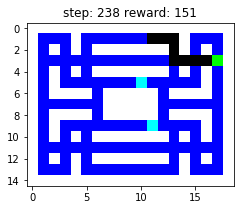

In [29]:



done = False
state = env.reset()
total_reward = 0
step   = 1

print('Using cuda?', tutil.USE_CUDA)

while not done:
    current_state = torch.FloatTensor(state).unsqueeze(0)
    if tutil.USE_CUDA:
        current_state = current_state.cuda()
        
    action = actor_critic.act(tutil.Variable(current_state))
    
    next_state, reward, done, _ = env.step(action.data[0, 0])
    total_reward += reward
    state = next_state
    
    image = torch.FloatTensor(state).permute(1, 2, 0).cpu().numpy()
    displayImage(image, step, total_reward)
    step += 1